In [2]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.stats import mode
from astropy.io import ascii
from itertools import chain
from matplotlib.ticker import MultipleLocator

## Generate Master Darks and Flat

In [3]:
# Load fits files for 2s and 1.5s dark exposures, use ms values for naming consistency
dark_1500ms = []
dark_2000ms = []
flats = []

# Make list of 2s dark data
for i in range(0,10):
    fname = '../data/dark_R_2s.0000000{0}.DARK.FIT'.format(i+1)
    try: 
        file = fits.open(fname)
    except FileNotFoundError:
        fname = fits.open('../data/dark_R_2s.00000010.DARK.FIT')
    dark_2000ms.append(file[0].data)
    file.close()

# 1.5s dark data 
for i in range(10,20):
    fname = '../data/dark_R_1.5s.000000{0}.DARK.FIT'.format(i+1)
    file = fits.open(fname)
    dark_1500ms.append(file[0].data)
    file.close()

# Flats data
for i in range(0,10):
    fname = '../data/flat_R.0000000{0}.FIT'.format(i+1)
    try: 
        file = fits.open(fname)
    except FileNotFoundError:
        fname = fits.open('../data/flat_R.00000010.FIT')
    flats.append(file[0].data)
    file.close()
    
m_dark_1500ms = np.empty(shape=dark_1500ms[0].shape)       # Make blank arrays of 1024 by 1024
m_dark_2000ms = np.empty(shape=dark_2000ms[0].shape)
m_flat = np.zeros(shape=flats[0].shape)
for y in range(1024):                          # For each y value
    for x in range(1024):                      # and each x value
        pixel_val_1500ms = []                             
        pixel_val_2000ms = []
        pixel_val_flat = []
        for dark in dark_1500ms:                           # and every frame
            pixel_val_1500ms.append(dark[y][x])     # Make a list of the value in the y,x pixel for 1.5s darks
        for dark in dark_2000ms:                              
            pixel_val_2000ms.append(dark[y][x])     # and the 2s darks
        for flat in flats:
            pixel_val_flat.append(flat[y][x])              # and the flats

        m_dark_1500ms[y][x] = np.median(pixel_val_1500ms)  # And store median value to the y,x pixel of the right master
        m_dark_2000ms[y][x] = np.median(pixel_val_2000ms)
        m_flat[y][x] = np.median(pixel_val_flat)
        
# Normalize master flat to have relative intensities varying around 1
m_flat /= np.mean(m_flat)

## Apply master fields to science images
We only want to do this once, as it is time intensive and only needs to be performed once and then saved to output files. We also grab the series of observation time stamps here.

In [4]:
'''
# Process science images with flats and darks (subtract dark, divide by flat)
# Comment this block out once run the first time, processing intensive and only needs to be done once to make the files

# Change working directory for processed data
os.chdir('../jupyter/')
print(os.getcwd())
os.chdir('../processed_data/')
print(os.getcwd())

# File extensions
files2000ms = np.array([*range(1, 902)])
files1500ms = np.array([*range(1001, 1193)])
files1500ms = np.append(files1500ms, [*range(2001, 3177)])
sequential_data = []
series = 0                                                               # Keep sequential file numbers
for i in files2000ms:
    file = fits.open('../data/hd209458_R_2s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    test_file = fits.PrimaryHDU((file[0].data-m_dark_2000ms)/m_flat)
    test_file.writeto('hd209458_processed_{}.fits'.format(str(series).zfill(5)), overwrite=True)
    file.close()
    series += 1
for i in files1500ms:
    file = fits.open('../data/hd209458_R_1_5s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    test_file = fits.PrimaryHDU((file[0].data-m_dark_1500ms)/m_flat)
    test_file.writeto('hd209458_processed_{}.fits'.format(str(series).zfill(5)), overwrite=True)
    file.close()
    series += 1

#'''

# Also make a list of the DATE-OBS keywords for each file in order

files2000ms = np.array([*range(1, 902)])
files1500ms = np.array([*range(1001, 1193)])
files1500ms = np.append(files1500ms, [*range(2001, 3177)])

observation_dates = np.array([])
for i in files2000ms:
    file = fits.open('../data/hd209458_R_2s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    date = file[0].header['DATE-OBS']
    observation_dates = np.append(observation_dates, date)
    file.close()
for i in files1500ms:
    file = fits.open('../data/hd209458_R_1_5s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))   
    date = file[0].header['DATE-OBS']
    observation_dates = np.append(observation_dates, date)
    file.close()
    
print(observation_dates)
print(len(observation_dates))

['2019-09-18T02:08:44.614' '2019-09-18T02:08:51.128'
 '2019-09-18T02:08:57.642' ..., '2019-09-18T06:27:09.671'
 '2019-09-18T06:27:16.606' '2019-09-18T06:27:23.527']
2269


## Bad Pixel Map
Generate the statistically significant bad pixel map from the flats and the darks with a requested significance level.

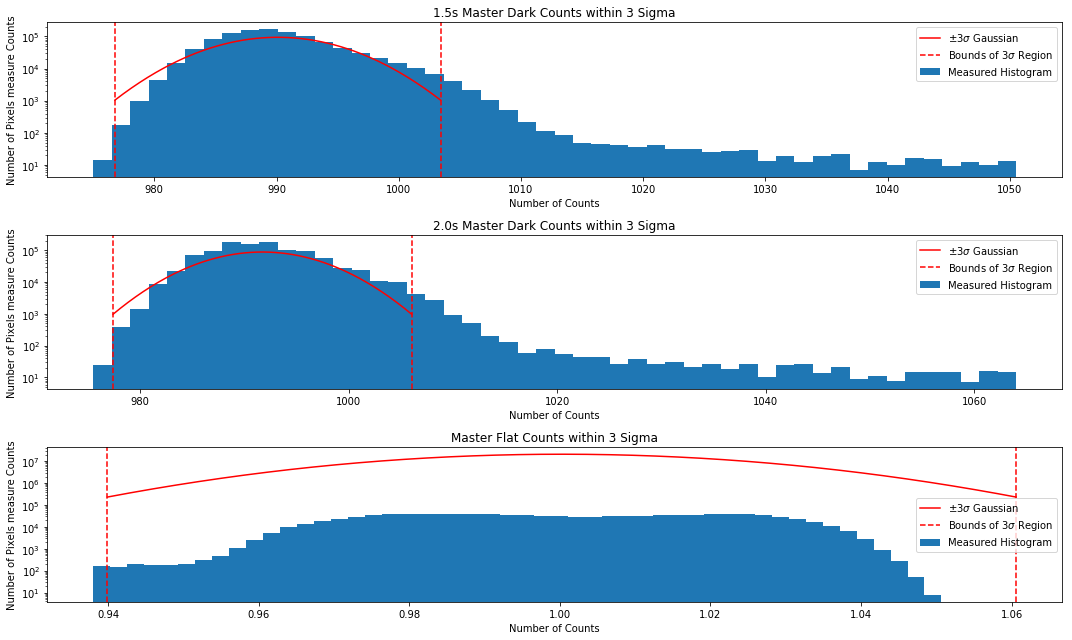

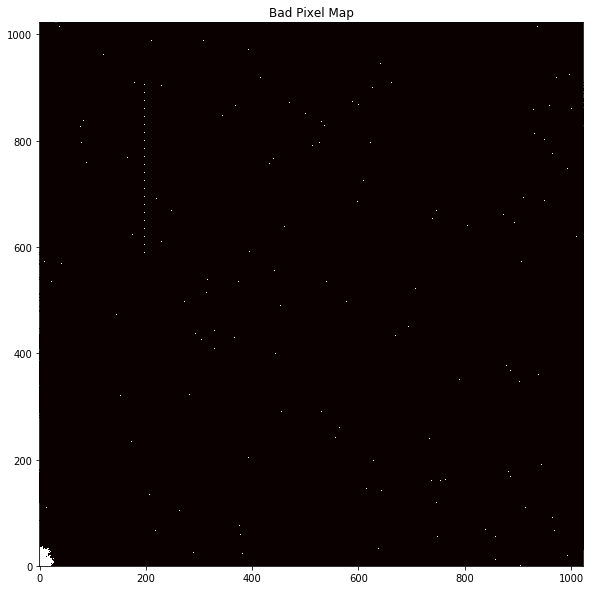

In [52]:
# Find stats for masters
flat_mean = np.mean(m_flat)
dark_mean1500 = np.mean(m_dark_1500ms)
dark_mean2000 = np.mean(m_dark_2000ms)
flat_std = np.std(m_flat)
dark_std1500 = np.std(m_dark_1500ms)
dark_std2000 = np.std(m_dark_2000ms)

# Significance level for cuts -------------------------------------------------
siglevel = 3

# Define a gaussian function
def gaussian(mu, std):
    global siglevel
    x = np.linspace(mu-siglevel*std, mu+siglevel*std, 200)
    func = np.exp(-pow((x-mu)/std, 2)/2)
    func /= np.sqrt(2*np.pi*std*std)
    func *= 1024*1024
    return x, func

def gaussian2(mu, std):
    x = np.linspace(mu-siglevel*std, mu+siglevel*std, 200)
    func = np.exp(-pow((x-mu)/std, 2)/2)
    func /= np.sqrt(2*np.pi*std*std)
    func *= 1024*1024
    return x, func/200

# Cur the data to be within  sigma
dark_1500ms_cut = [x for x in m_dark_1500ms.flatten() if x < dark_mean1500+siglevel*dark_std1500 
                   and x > dark_mean1500-siglevel*dark_std1500]
dark_2000ms_cut = [x for x in m_dark_2000ms.flatten() if x < dark_mean2000+siglevel*dark_std2000 
                   and x > dark_mean2000-siglevel*dark_std2000]
flat_cut = [x for x in m_flat.flatten() if x < flat_mean+siglevel*flat_std and x > flat_mean-siglevel*flat_std]

# Plot histograms
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.hist(dark_1500ms_cut, log=True, bins=50, label='Measured Histogram')
ax2.hist(dark_2000ms_cut, log=True, bins=50, label='Measured Histogram')
ax3.hist(flat_cut, log=True, bins=50, label='Measured Histogram')
ax1.set_title('1.5s Master Dark Counts within 3 Sigma')
ax2.set_title('2.0s Master Dark Counts within 3 Sigma')
ax3.set_title('Master Flat Counts within 3 Sigma')
ax1.plot(*gaussian(np.mean(dark_1500ms_cut), np.std(dark_1500ms_cut)), 'r-', label=r'$\pm3\sigma$ Gaussian')
ax2.plot(*gaussian(np.mean(dark_2000ms_cut), np.std(dark_2000ms_cut)), 'r-', label=r'$\pm3\sigma$ Gaussian')
ax3.plot(*gaussian(np.mean(flat_cut), np.std(flat_cut)), 'r-', label=r'$\pm3\sigma$ Gaussian')
ax1.set_xlabel('Number of Counts')
ax2.set_xlabel('Number of Counts')
ax3.set_xlabel('Number of Counts')
ax1.set_ylabel('Number of Pixels measure Counts')
ax2.set_ylabel('Number of Pixels measure Counts')
ax3.set_ylabel('Number of Pixels measure Counts')

ax1.axvline(x=np.mean(dark_1500ms_cut)-siglevel*np.std(dark_1500ms_cut), 
            linestyle='--', color='r', label=r'Bounds of 3$\sigma$ Region')
ax1.axvline(x=np.mean(dark_1500ms_cut)+siglevel*np.std(dark_1500ms_cut), linestyle='--', color='r')
ax2.axvline(x=np.mean(dark_2000ms_cut)-siglevel*np.std(dark_2000ms_cut), 
            linestyle='--', color='r', label=r'Bounds of 3$\sigma$ Region')
ax2.axvline(x=np.mean(dark_2000ms_cut)+siglevel*np.std(dark_2000ms_cut), linestyle='--', color='r')
ax3.axvline(x=np.mean(flat_cut)-siglevel*np.std(flat_cut), 
            linestyle='--', color='r', label=r'Bounds of 3$\sigma$ Region')
ax3.axvline(x=np.mean(flat_cut)+siglevel*np.std(flat_cut), linestyle='--', color='r')



ax1.legend()
ax2.legend()
ax3.legend()
fig.tight_layout()
plt.show()
plt.close()

# Make bad pixel map and plot
bad_pixel_map = np.ones(shape=(1024, 1024))
for y in range(1024):
    for x in range(1024):
        if (m_dark_1500ms[y][x] > dark_mean1500+siglevel*dark_std1500 or 
            m_dark_1500ms[y][x] < dark_mean1500-siglevel*dark_std1500):
            bad_pixel_map[y][x] = 0
        elif (m_dark_2000ms[y][x] > dark_mean2000+siglevel*dark_std2000 or 
              m_dark_2000ms[y][x] < dark_mean2000-siglevel*dark_std2000):
            bad_pixel_map[y][x] = 0
        elif m_flat[y][x] > flat_mean+siglevel*flat_std or m_flat[y][x] < flat_mean-siglevel*flat_std:
            bad_pixel_map[y][x] = 0
fig = plt.figure(figsize=(10, 10))
plt.imshow(bad_pixel_map, cmap='hot_r')
plt.title('Bad Pixel Map')
plt.ylim(0, 1023)
plt.show()

## Reference Star Lightcurves
All of this comes after solving for the WCS coordinates and using Source Extractor to get a catalog of sources in the frame. These steps were run remotely on uhura and vulcan. 

Create the lightcurves for the reference stars

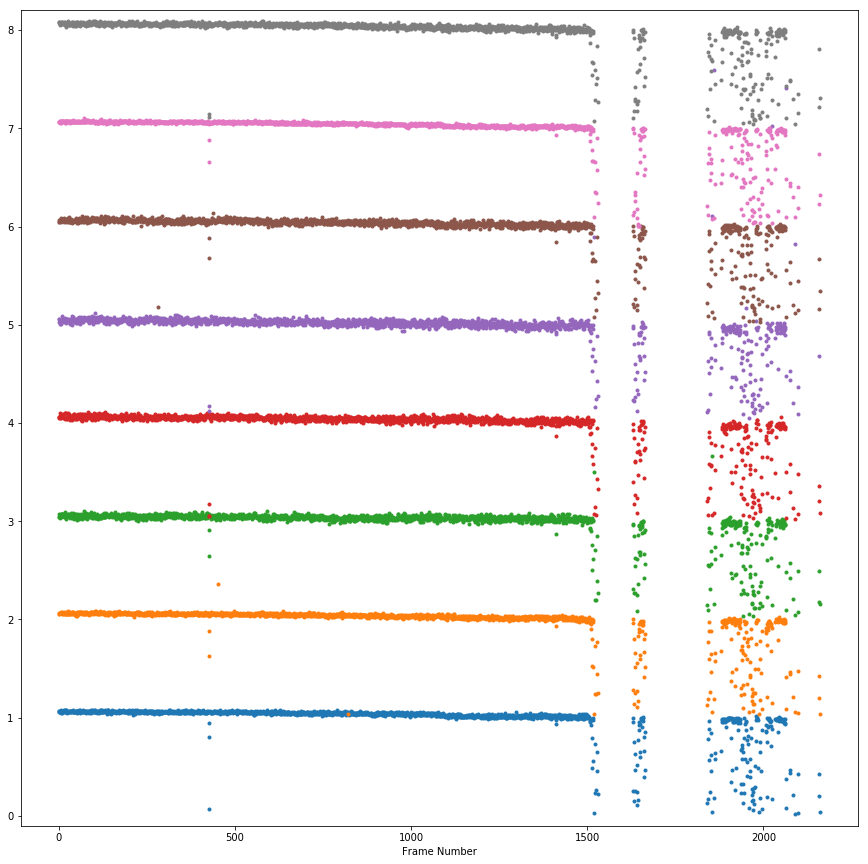

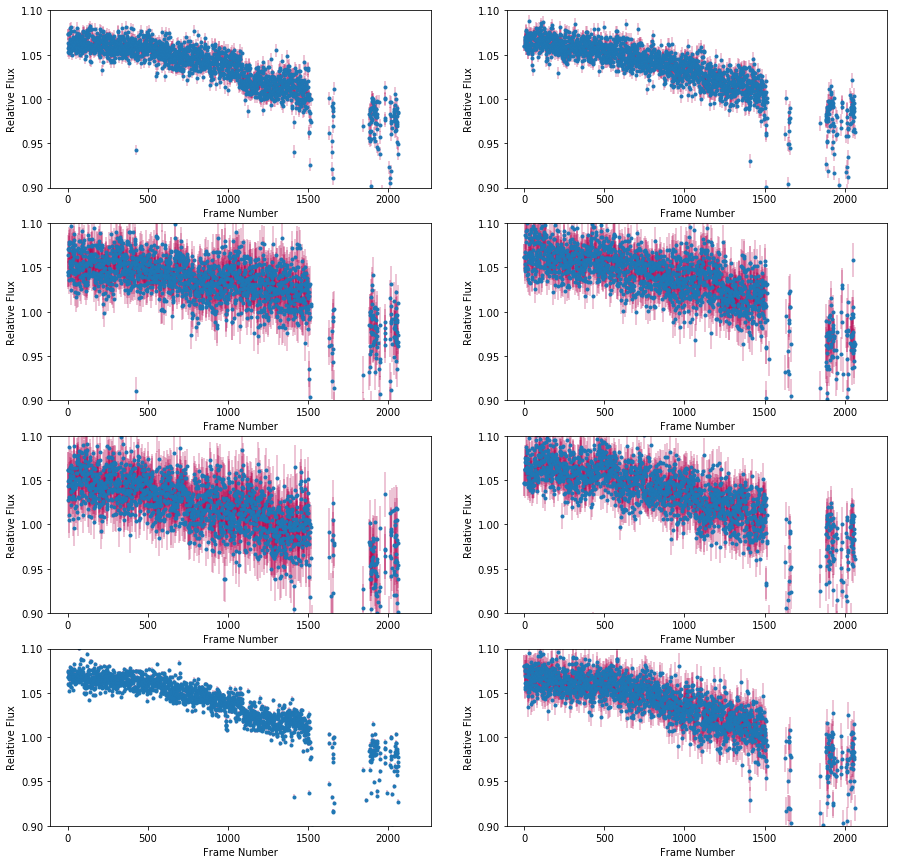

In [59]:
files = sorted(os.listdir('../lightcurve'))
files = [file for file in files if file[-4:]=='.dat']

file_2s = [file for file in files if file[-11:-10] == str(0)]      # Grab the 2s exposure catalogs
file_1_5s = [file for file in files if file[-11:-10] == str(5)]      # Grab the 1.5s exposure catalogs

fig1, ax1 = plt.subplots(1, 1, figsize=(15, 15))
fig2, ax2 = plt.subplots(4, 2, figsize=(15, 15))
ax2 = ax2.flatten()

maxfiles = 0
full_flux = []
full_err = []
for i in range(len(file_2s)):
    data1 = np.loadtxt('../lightcurve/{0}'.format(file_2s[i]), skiprows=1)
    fnum1, count1, sigcount1 = data1.T
    flux1 = count1/2
    sigflux1 = sigcount1/2
    
    data2 = np.loadtxt('../lightcurve/{0}'.format(file_1_5s[i]), skiprows=1)
    fnum2, count2, sigcount2 = data2.T
    flux2 = count2/1.5
    sigflux2 = sigcount2/1.5
    
    fnum = np.append(fnum1, fnum2)
    flux = np.append(flux1, flux2)
    sigflux = np.append(sigflux1, sigflux2)
    
    sigflux /= np.mean(flux)
    flux /= np.mean(flux)

    ax1.plot(fnum, flux+i, '.')
    ax2[i].errorbar(fnum, flux, fmt='.', yerr=sigflux, ecolor=(0.7, 0, 0.3, 0.3))
    ax2[i].set_ylim(.9, 1.1)
    
    if maxfiles < fnum[-1:]:
        maxfiles = fnum[-1:]
        
    full_flux.append(flux)
    full_err.append(sigflux)

ax1.set_ylim(-.1, 8.2)
for i in range(0, 8):
    ax2[i].set_xlabel('Frame Number')
    ax2[i].set_ylabel('Relative Flux')
plt.show()

Find the average lightcurve of reference stars and error, for normalization purposes.

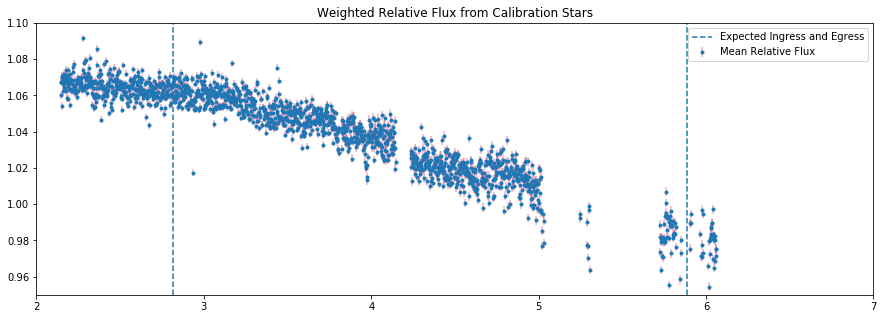

In [60]:
time = []
weighted_mean = []
weighted_mean_err = []
for i in range(1737):
    num = 0
    denom = 0
    for j in range(8):
        num += full_flux[j][i]/(full_err[j][i]**2)
        denom += 1/(full_err[j][i]**2)
    weighted_mean.append(num/denom)
    weighted_mean_err.append(np.sqrt(1/denom))
    time.append(int(observation_dates[int(fnum[i])][11:13])+int(observation_dates[int(fnum[i])][14:16])/60
                +float(observation_dates[int(fnum[i])][17:])/60/60)
    
fig, ax = plt.subplots(figsize=(15, 5))
ax.errorbar(time, weighted_mean, yerr=weighted_mean_err, fmt='.', ecolor=(0.7, 0, 0.3, 0.3), label='Mean Relative Flux')
ax.set_title('Weighted Relative Flux from Calibration Stars')
ax.set_ylim(0.95, 1.1)
ax.set_xlim(2, 7)
ax.axvline(x=2+49/60, linestyle='--', label='Expected Ingress and Egress')
ax.axvline(x=5+53/60, linestyle='--')
plt.legend()
plt.show()

# Lightcurve for Object Star
Plot the normalized lightcurve of HD 209458

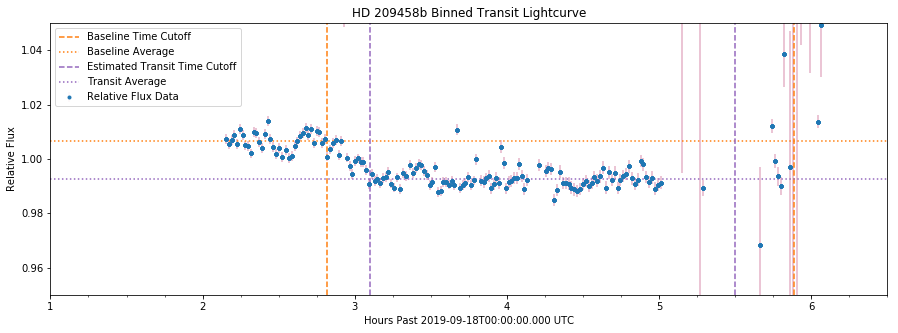

Transit Average: 0.99249 +/- 0.00031
Baseline Average: 1.00666 +/- 0.00067
Transit Depth: 0.01418 +/- 0.00074


In [62]:
data_obj2_0 = ascii.read('../lctable_star2_0.cat')
data_obj1_5 = ascii.read('../lctable_star1_5.cat')

flux_obj1 = data_obj2_0['FLUX_APER']/2
flux_obj2 = data_obj1_5['FLUX_APER']/1.5

fluxerr_obj1 = data_obj2_0['FLUXERR_APER']/2
fluxerr_obj2 = data_obj1_5['FLUXERR_APER']/1.5

flux_obj = np.append(flux_obj1,flux_obj2)
fluxerr_obj = np.append(fluxerr_obj1,fluxerr_obj2)
flux_obj_rescaled = flux_obj/np.mean(flux_obj)
fluxerr_obj_rescaled = fluxerr_obj/np.mean(flux_obj)
#ratio r_i
r_i = flux_obj_rescaled/weighted_mean
rerr_i = r_i**2*((np.array(fluxerr_obj_rescaled)/np.array(flux_obj_rescaled))**2 +
                 (np.array(weighted_mean_err)/np.array(weighted_mean)**2))

# Bin data
n = 10
bintime = list(chain.from_iterable([np.mean(time[i:i+n])]*n for i in range(0,len(time),n)))
binr_i = list(chain.from_iterable([np.mean(r_i[i:i+n])]*n for i in range(0,len(r_i),n)))
binrerr_i = list(chain.from_iterable([np.mean(rerr_i[i:i+n])]*n for i in range(0,len(rerr_i),n)))
    
# Take the baseline to be avg of all points outside of transit time
baseline = np.array([r_i[i] for i in range(len(r_i)) 
                    if time[i] < 2+49/60 or time[i] > 5+53/60
                    and r_i[i] < 1.1 and r_i[i] > 0.9])
base_avg = np.mean(baseline.flatten())
base_std = np.std(baseline.flatten())/np.sqrt(len(baseline))

transitline = np.array([r_i[i] for i in range(len(r_i)) 
                        if time[i] > 3.1 and time[i] < 5.5 
                        and r_i[i] < 1.02 and r_i[i] > 0.96])
transit_avg = np.mean(transitline.flatten())
transit_std = np.std(transitline.flatten())/np.sqrt(len(transitline))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.errorbar(bintime, binr_i, yerr=binrerr_i, fmt='.', ecolor=(0.7, 0, 0.3, 0.3/n), label='Relative Flux Data')
ax.set_ylim(0.95, 1.05)
ax.set_xlim(1.7, 6.5)
ax.axvline(x=2+49/60, linestyle='--', color='C1', label='Baseline Time Cutoff')
ax.axvline(x=5+53/60, linestyle='--', color='C1')
ax.axhline(y=base_avg, linestyle=':', color='C1', label='Baseline Average')
ax.axvline(x=3.1, linestyle='--', color='C4', label='Estimated Transit Time Cutoff')
ax.axvline(x=5.5, linestyle='--', color='C4')
ax.axhline(y=transit_avg, linestyle=':', color='C4', label='Transit Average')
ax.set_xticks(range(1, 7), minor=True)
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlabel('Hours Past 2019-09-18T00:00:00.000 UTC')
ax.set_ylabel('Relative Flux')
ax.set_title('HD 209458b Binned Transit Lightcurve')
plt.legend()
plt.show()

print('Transit Average: {0:1.5f} +/- {1:1.5f}'.format(transit_avg, transit_std))
print('Baseline Average: {0:1.5f} +/- {1:1.5f}'.format(base_avg, base_std))
print('Transit Depth: {0:1.5f} +/- {1:1.5f}'.format(base_avg-transit_avg, np.sqrt(transit_std**2+base_std**2)))

The planet-to-star radius ratio $\left(\frac{r}{R}\right)^{2}=\epsilon$,
$$\frac{r}{R}=\sqrt{\epsilon}=0.11908$$

$$\sigma_{\frac{r}{R}}=\frac{1}{2}\epsilon^{-\frac{1}{2}}\sigma_{\epsilon}=0.00311$$

$$\frac{r}{R}_{measured}=0.11908\pm0.00311$$

Comparing to the actual data, $r=96514\ km$, $R=834612\ km$, and 
$$\left(\frac{r}{R}\right)_{theo}=0.11564$$.


Miscellaneous scratch work:

In [43]:
rj = 1.38*7.149e9
rs = 1.203*6.955e10

print('{0:4g}      {1:4g}'.format(rj, 0.018*7.149e9))

print()

print(pow(rj/rs, 2))
print( pow(rj/rs, 2) * np.sqrt( (0.18/1.38)**2 + (0.061/1.203)**2 ) )

d = 0.013903
sd = 0.001945
de = 0.01418
sde = 0.00074
print( (de-d)/(np.sqrt(sd**2+sde**2)) )


print('{0:4.3g} +/- {1:4.2g}'.format(rs*0.11564, rs*0.00311))

9.86562e+09      1.28682e+08

0.013903471263774616
0.00194571062665
0.133108098594
9.68e+09 +/- 2.6e+08
